In [24]:
# Parte 3: Detección de tópicos con LDA

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import gensim
from gensim import corpora

In [26]:
# Cargar los datos procesados
print("Cargando datos...")
df = pd.read_csv('./data/processed/processedClimateTwitterData.csv')

custom_stop_words = set(ENGLISH_STOP_WORDS)
# Eliminamos las stop words de la limpieza del texto para que no se tengan en cuenta
# esto debido a que salen multiples veces y pueden afectar los resultados y no aportar 
# informacion significativa
custom_stop_words.update(['numero', 'cuenta_usuario', 'link_url'])

print("Creando matriz de términos-documentos...")
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(custom_stop_words))
dtm = vectorizer.fit_transform(df['processed_text'])

Cargando datos...
Creando matriz de términos-documentos...


In [27]:
# Función para imprimir los top palabras por tópico
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Tópico {topic_idx + 1}: {', '.join(top_words)}")


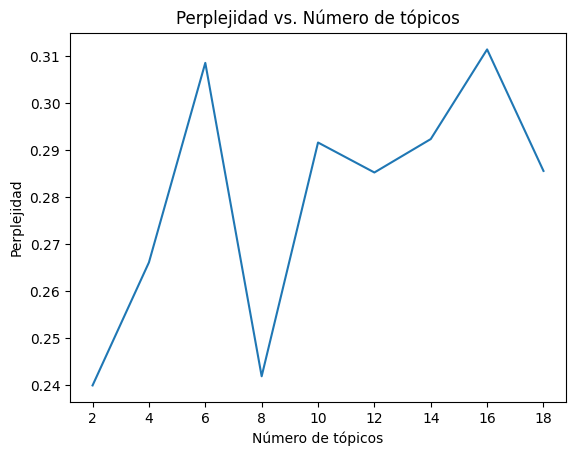

In [28]:
def compute_coherence_values(texts, start, limit, step):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=4)
        coherence_model = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        model_list.append(model)
    return model_list, coherence_values

texts = df['processed_text'].apply(lambda x: x.split()).tolist()
model_list, coherence_values = compute_coherence_values(texts, 2, 20, 2)

plt.plot(range(2, 20, 2), coherence_values)
plt.xlabel("Número de tópicos")
plt.ylabel("Perplejidad")
plt.title("Perplejidad vs. Número de tópicos")
plt.savefig('./data/images/perplexity_plot.png')
# plt.close()

In [32]:
display(coherence_values)

[0.23992278368092654,
 0.2661003493319121,
 0.3085490948697501,
 0.24186637662642213,
 0.29160530330798207,
 0.28522839534113004,
 0.2923390347347539,
 0.31141193789603283,
 0.28555688420190123]

In [29]:
# Seleccionar el número óptimo de tópicos
optimal_num_topics = range(2, 20, 2)[np.argmin(coherence_values)]
print(f"Número óptimo de tópicos: {optimal_num_topics}")

# Entrenar el modelo LDA final
print("Entrenando el modelo LDA final...")
lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda_output = lda_model.fit_transform(dtm)

# Imprimir los top palabras por tópico
print("\nTop palabras por tópico:")
print_top_words(lda_model, vectorizer.get_feature_names_out(), 10)

Número óptimo de tópicos: 2
Entrenando el modelo LDA final...

Top palabras por tópico:
Tópico 1: climatechange, sustainability, environment, amp, climatecrisis, globalwarming, climate, greennewdeal, climateaction, need
Tópico 2: climatestrike, climate, climateaction, fridaysforfuture, climatechange, today, people, change, action, student


Generando nubes de palabras...


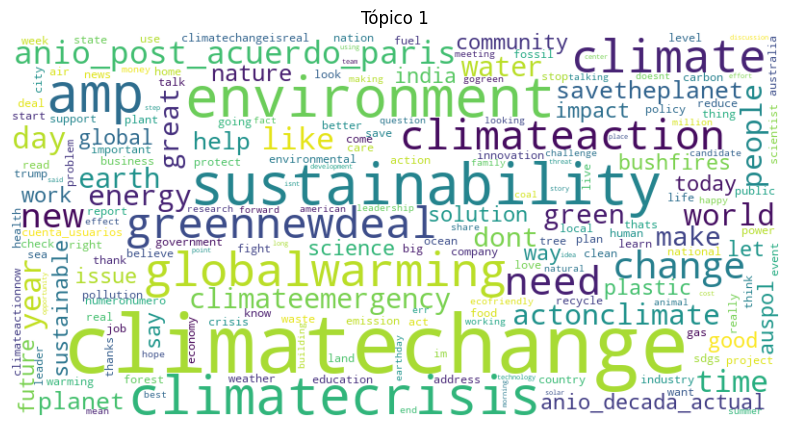

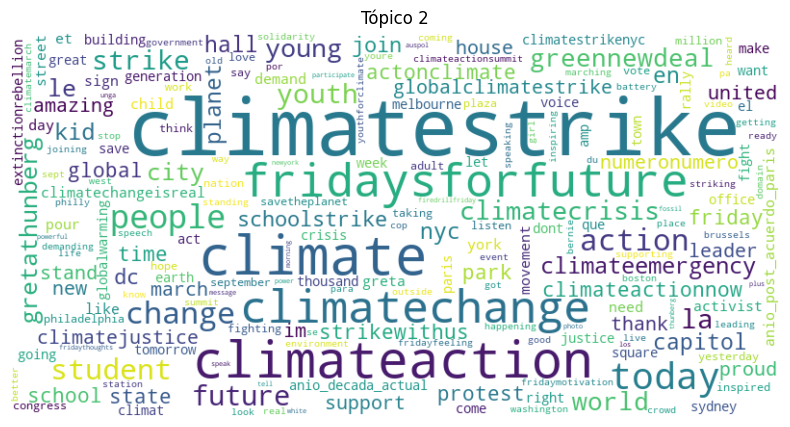

In [30]:
# Crear nubes de palabras para cada tópico
print("Generando nubes de palabras...")
for idx, topic in enumerate(lda_model.components_):
    top_words = dict(zip(vectorizer.get_feature_names_out(), topic))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Tópico {idx + 1}')
    plt.savefig(f'./data/images/wordcloud_topic_{idx + 1}.png')
    # plt.close()

In [31]:
# Asignar tópicos a los tweets
df['dominant_topic'] = lda_output.argmax(axis=1)

# Guardar resultados
print("Guardando resultados...")
df.to_csv('./data/processed/tweets_with_topics.csv', index=False)

print("Proceso completado.")

Guardando resultados...
Proceso completado.
